In [4]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# CSVファイルを読み込む
df = pd.read_csv('~/lab/data/dataset/dataset_all.csv')

# データフレームの基本情報を表示
print("データフレームの形状:", df.shape)
print("\nデータフレームの最初の行:")
print(df.head())
print("\nデータフレームの統計情報:")
print(df.describe())
print("\nデータ型:")
print(df.dtypes)
print("\nNULL値の確認:")
print(df.isnull().sum())



データフレームの形状: (1068, 13)

データフレームの最初の行:
   #PMT_num  Charge(pC)  Charge_err(pC)  light_power(def:(15dB, 5V)=1)  \
0         1     1.83704        0.363831                       0.279857   
1         2     9.33347        0.027628                       0.279857   
2         3    26.87980        0.048025                       0.279857   
3         4     8.95515        2.396030                       0.279857   
4         1     1.34065        0.247728                       0.280068   

   attenuation_db  pd_volt   x   y    z           r  cos(alpha)  \
0              20  4.42493 -35 -35  157  103.693057    0.737754   
1              20  4.42493 -35 -35  157  125.108953    0.611467   
2              20  4.42493 -35 -35  157   76.500000    1.000000   
3              20  4.42493 -35 -35  157  103.693057    0.737754   
4              20  4.42826 -35 -35  147   96.551800    0.688749   

   r_from_center  cos(alpha_from_center)  
0     129.541499                0.841429  
1     147.244694            

Filtered raw rows: 16
After threshold (>=20): 12
     #PMT_num  Charge(pC)  Charge_err(pC)  light_power(def:(15dB, 5V)=1)  \
104         1    177.6820        0.198939                       0.981200   
136         1     55.2164        0.072638                       0.309555   
148         1     80.4424        0.102947                       0.309650   
228         1    393.0390        0.415033                       0.981700   
236         1     80.8508        0.105978                       0.982250   

     attenuation_db  pd_volt   x   y    z     r  cos(alpha)  r_from_center  \
104              15  4.90600 -35  35  117  36.5         1.0           69.0   
136              20  4.89450 -35  35  117  36.5         1.0           69.0   
148              20  4.89600 -35  35  107  26.5         1.0           59.0   
228              15  4.90850 -35  35   97  16.5         1.0           49.0   
236              15  4.91125 -35  35  147  66.5         1.0           99.0   

     cos(alpha_from_cente

/tmp/ipykernel_106212/2457895615.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['charge_per_power'] = filtered_df['Charge(pC)'] / filtered_df['light_power(def:(15dB, 5V)=1)']


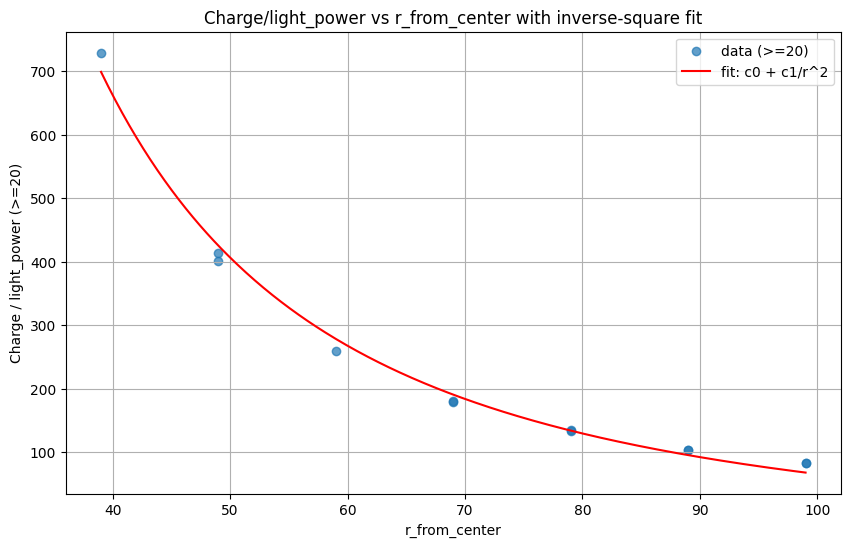

In [17]:
# Filter the dataframe for PMT_num=1, x=-35, y=35
filtered_df = df[(df['#PMT_num'] == 1) & (df['x'] == -35) & (df['y'] == 35)]
print("Filtered raw rows:", len(filtered_df))

# Compute Charge/light_power and apply threshold >= 20
filtered_df['charge_per_power'] = filtered_df['Charge(pC)'] / filtered_df['light_power(def:(15dB, 5V)=1)']
filtered_df = filtered_df[filtered_df['charge_per_power'] >= 20]
print("After threshold (>=20):", len(filtered_df))
print(filtered_df.head())

# Prepare arrays for fitting
import numpy as np
from scipy.optimize import curve_fit

x = filtered_df['r_from_center'].to_numpy(dtype=float)
y = filtered_df['charge_per_power'].to_numpy(dtype=float)
mask = np.isfinite(x) & np.isfinite(y) & (x > 0)
x = x[mask]
y = y[mask]

# Define model: y = c0 + c1 / r^2
def inv_square_model(r, c0, c1):
    return c0 + c1 / (r ** 2)

# Initial guesses
c0_init = 100.0
c1_init = 6000.0
p0 = [c0_init, c1_init]

# Range for plotting
x_min, x_max = float(np.min(x)), float(np.max(x))

# Fit
try:
    popt, pcov = curve_fit(inv_square_model, x, y, p0=p0, maxfev=20000)
    c0, c1 = popt
    print(f"Fit succeeded: c0={c0:.4g}, c1={c1:.4g}")
except Exception as e:
    print("Fit failed:", e)
    c0, c1 = p0

# Plot: scatter + fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='data (>=20)', alpha=0.7)

x_fit = np.linspace(x_min, x_max, 400)
y_fit = inv_square_model(x_fit, c0, c1)
plt.plot(x_fit, y_fit, color='red', label='fit: c0 + c1/r^2')

plt.xlabel('r_from_center')
plt.ylabel('Charge / light_power (>=20)')
plt.title('Charge/light_power vs r_from_center with inverse-square fit')
plt.grid(True)
plt.legend()
plt.show()